Setup Environment

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
# --- Dataset Info ---
# Path to the unzipped 'realwaste-main/RealWaste' folder
SOURCE_DIR = "realwaste1/realwaste-main/RealWaste" 
# Path to a new folder where we'll organize the data
BASE_DIR = "data" 
CLASSES = [
    "Cardboard", "Food Organics", "Glass", "Metal", 
    "Miscellaneous Trash", "Paper", "Plastic", 
    "Textile Trash", "Vegetation"
]
K_CLASSES = len(CLASSES) # This is K from your assignment

# --- Split Ratios (Q3) ---
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15 # 70 + 15 + 15 = 100

# --- Model & Training Params ---
# Note: The paper uses 524x524, which is VERY large and slow.
# Start with 256x256 or 128x128 if training is too slow on your computer.
IMG_SIZE = 256 
BATCH_SIZE = 32 # Number of images to process at once
EPOCHS = 20 # As requested in Q7

In [5]:
# Create the base directory
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR) # Clear out old data if it exists
os.makedirs(BASE_DIR)

# Create train, val, and test folders
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Create class subfolders in each
for cls in CLASSES:
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(val_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

In [6]:
print("Splitting and moving files...")
for cls in CLASSES:
    cls_path = os.path.join(SOURCE_DIR, cls)
    all_files = glob.glob(os.path.join(cls_path, '*.jpg'))
    
    # Create labels for stratification
    labels = [cls] * len(all_files)
    
    # 1. Split into train (70%) and temp (30%)
    train_files, temp_files = train_test_split(
        all_files, 
        test_size=(1 - TRAIN_RATIO), 
        random_state=42, 
        stratify=labels
    )
    
    # 2. Split temp (30%) into val (15%) and test (15%)
    # test_size = 0.50 (of 30%) = 15% of total
    relative_test_size = TEST_RATIO / (VAL_RATIO + TEST_RATIO) 
    val_files, test_files = train_test_split(
        temp_files, 
        test_size=relative_test_size, 
        random_state=42, 
        stratify=[cls] * len(temp_files) # Stratify the temp set
    )
    
    # Function to copy files
    def copy_files(files, dest_folder):
        for f in files:
            shutil.copy(f, os.path.join(dest_folder, cls))
            
    # Copy files to their new homes
    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)
    copy_files(test_files, test_dir)

print("File splitting complete.")

Splitting and moving files...
File splitting complete.


In [7]:
# Use Keras utility to create datasets from the directories
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int' # Labels will be integers (0, 1, 2...8)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False # IMPORTANT: Do not shuffle test data for evaluation
)

# Verify the class names (Keras automatically finds them)
print(f"Class names found: {train_ds.class_names}")

Found 3320 files belonging to 9 classes.
Found 713 files belonging to 9 classes.
Found 719 files belonging to 9 classes.
Class names found: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [8]:
def build_model(optimizer_choice='adam'):
    # Define the model sequentially
    model = keras.Sequential(name="My_First_CNN")
    
    # 1. Input Layer (Define the shape)
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    # 2. Preprocessing: Normalize pixels from [0, 255] to [0, 1]
    # This is better than doing it in the generator as it's part of the model.
    model.add(layers.Rescaling(1./255))
    
    # --- Modification: Add Data Augmentation (as suggested in paper) ---
    # This helps prevent overfitting and makes the model more robust.
    # It "modifies" the network as allowed by the prompt.
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    # -------------------------------------------------------------------
    
    # Block 1 (Q4)
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv1"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="pool1"))
    
    # Block 2 (Q4)
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name="pool2"))
    
    # Flatten (Q4)
    model.add(layers.Flatten(name="flatten"))
    
    # Fully Connected Block (Q4)
    model.add(layers.Dense(units=128, activation='relu', name="dense1"))
    model.add(layers.Dropout(rate=0.3, name="dropout"))
    
    # Output Layer (Q4)
    model.add(layers.Dense(units=K_CLASSES, activation='softmax', name="output"))
    
    # --- Compile the model ---
    
    # Define the optimizer based on the choice
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Q8: Adam
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01) # Q10: Standard SGD
    elif optimizer_choice == 'sgd_momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Q10: SGD with Momentum
    else:
        raise ValueError("Unknown optimizer")
        
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy', # Use this because our labels are integers (0, 1, 2...)
        metrics=['accuracy']
    )
    
    return model

Build and Train (Adam)

In [9]:
# Build the model with the Adam optimizer
model_adam = build_model(optimizer_choice='adam')

# Print a summary
model_adam.summary()

# Train the model for 20 epochs
print("Training model with Adam...")
history_adam = model_adam.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Model: "My_First_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,510,729 (120.20 MB)

 Trainable params: 31,510,729 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

Training model with Adam...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 849ms/step - accuracy: 0.2428 - loss: 2.4490 - val_accuracy: 0.3380 - val_loss: 1.7879
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 763ms/step - accuracy: 0.3581 - loss: 1.7696 - val_accuracy: 0.3829 - val_loss: 1.6691
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 774ms/step - accuracy: 0.3855 - loss: 1.6764 - val_accuracy: 0.3997 - val_loss: 1.6839
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 777ms/step - accuracy: 0.4437 - loss: 1.5587 - val_accuracy: 0.4656 - val_loss: 1.4719
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 765ms/step - accuracy: 0.4590 - loss: 1.5122 - val_accuracy: 0.4109 - val_loss: 1.5815
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 740ms/step - accuracy: 0.4732 - loss: 1.4395 - val_accuracy: 0.5175 - val_loss: 1.4661
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 747ms/step - accuracy: 0.5075 - loss: 1.3735 - val_accuracy: 0.5456 - val_loss: 1.3292
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 739ms/step 

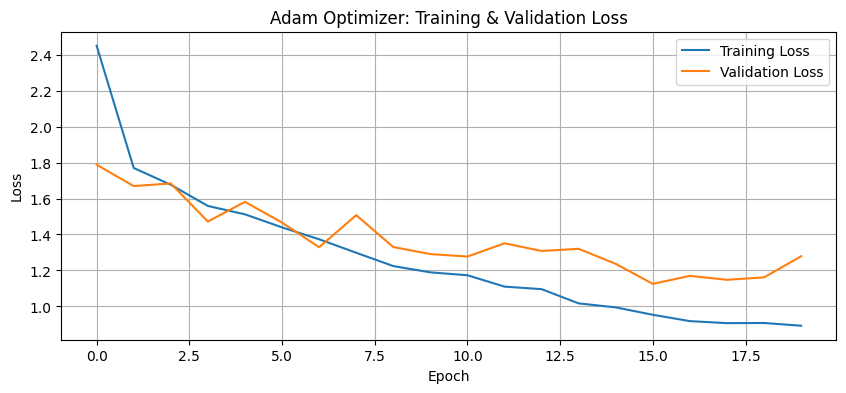

In [10]:
def plot_loss(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_adam, 'Adam Optimizer: Training & Validation Loss')

Train SGD and SGD-with-Momentum


Training model with Standard SGD...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 653ms/step - accuracy: 0.2148 - loss: 2.1081 - val_accuracy: 0.2020 - val_loss: 2.0337
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 673ms/step - accuracy: 0.2669 - loss: 1.9906 - val_accuracy: 0.3324 - val_loss: 1.8738
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 633ms/step - accuracy: 0.3187 - loss: 1.8616 - val_accuracy: 0.3815 - val_loss: 1.7500
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 634ms/step - accuracy: 0.3563 - loss: 1.7744 - val_accuracy: 0.2833 - val_loss: 2.0550
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 666ms/step - accuracy: 0.3840 - loss: 1.7193 - val_accuracy: 0.4642 - val_loss: 1.5207
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 710ms/step - accuracy: 0.3982 - loss: 1.6593 - val_accuracy: 0.4236 - val_loss: 1.5536
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 733ms/step - accuracy: 0.4187 - loss: 1.6103 - val_accuracy: 0.4446 - val_loss: 1.4989
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 72

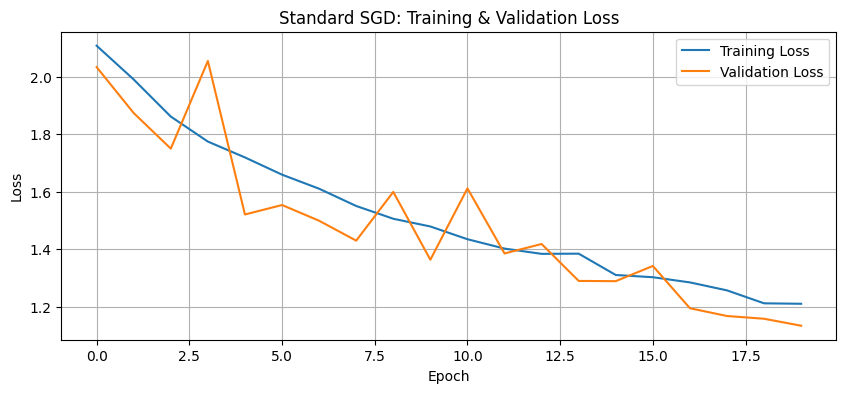


Training model with SGD + Momentum...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 707ms/step - accuracy: 0.1831 - loss: 2.1660 - val_accuracy: 0.1669 - val_loss: 2.1643
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 717ms/step - accuracy: 0.2057 - loss: 2.0958 - val_accuracy: 0.2412 - val_loss: 2.0039
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 718ms/step - accuracy: 0.2133 - loss: 2.0672 - val_accuracy: 0.3310 - val_loss: 1.8922
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 678ms/step - accuracy: 0.2232 - loss: 2.0133 - val_accuracy: 0.1669 - val_loss: 2.1585
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 661ms/step - accuracy: 0.1840 - loss: 2.1172 - val_accuracy: 0.2454 - val_loss: 1.9599
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 68s 654ms/step - accuracy: 0.2286 - loss: 2.0167 - val_accuracy: 0.1795 - val_loss: 2.1121
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 645ms/step - accuracy: 0.2310 - loss: 2.0118 - val_accuracy: 0.2917 - val_loss: 1.8529
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 

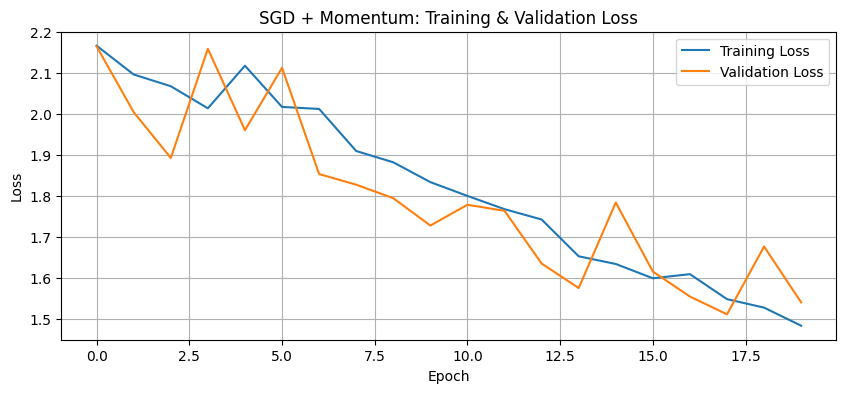

In [11]:
# --- Model 2: Standard SGD ---
print("\nTraining model with Standard SGD...")
model_sgd = build_model(optimizer_choice='sgd')
history_sgd = model_sgd.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)
plot_loss(history_sgd, 'Standard SGD: Training & Validation Loss')

# --- Model 3: SGD with Momentum ---
print("\nTraining model with SGD + Momentum...")
model_momentum = build_model(optimizer_choice='sgd_momentum')
history_momentum = model_momentum.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)
plot_loss(history_momentum, 'SGD + Momentum: Training & Validation Loss')

In [12]:
print(f"Adam min val_loss:     {min(history_adam.history['val_loss'])}")
print(f"SGD min val_loss:      {min(history_sgd.history['val_loss'])}")
print(f"Momentum min val_loss: {min(history_momentum.history['val_loss'])}")

Adam min val_loss:     1.125752329826355
SGD min val_loss:      1.1334236860275269
Momentum min val_loss: 1.5106439590454102


Evaluating model on the test dataset...
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.6147 - loss: 1.1917

Test Accuracy: 61.47%
Test Loss: 1.1917
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.51      0.56      0.53        70
      Food Organics       0.69      0.76      0.72        62
              Glass       0.75      0.67      0.71        64
              Metal       0.61      0.61      0.61       119
Miscellaneous Trash       0.50      0.29      0.37        75
              Paper       0.55      0.63      0.59        76
            Plastic       0.58      0.66      0.62       139
      Textile Trash       0.61      0.40      0.48        48
         Vegetation       0.77      0.91      0.83        66

           accuracy                           0.61       719
          macro avg       0.62      0.61      0.61       719
       weighted avg       0.61      0.61     

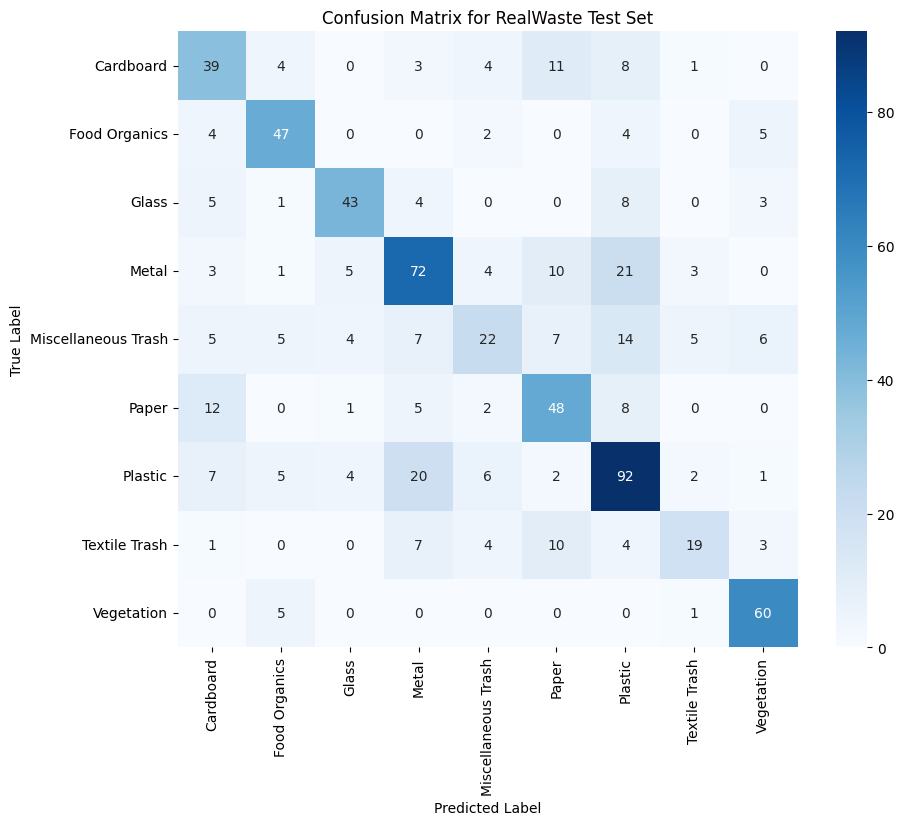

In [13]:
# Select best model (model_adam)
best_model = model_adam

# 1. Get Test Loss and Test Accuracy
print("Evaluating model on the test dataset...")
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- Get Confusion Matrix, Precision, and Recall ---

# 1. Get all true labels (y_true) from the test set
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 2. Get all predicted labels (y_pred)
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to class index

# 3. Print Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# 4. Plot Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', # Format as integers
    cmap='Blues', 
    xticklabels=CLASSES, 
    yticklabels=CLASSES
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RealWaste Test Set')
plt.show()